In [84]:
#| default_exp ndwi_class

# NDWI 

In [85]:
#|hide
from nbdev.showdoc import *

In [86]:
#|export
import rasterio
import numpy as np
import matplotlib.pyplot as plt 

from flood_exercise import utils_func
from flood_exercise import const_vals as CONST

In [90]:
#|export

class ndwi():

  def __init__(self,
      path_to_imgs : str , # path to the folder that contains the images
      ):
     
     # get list of tif files
     self.list_of_files = utils_func.load_list_paths(path_to_imgs,filter_file = True)
     self.list_of_files = [x for x in self.list_of_files if 'Bolivia' in x]
     
     # calculate NDWI and NDWI mask per image
     for path in self.list_of_files[25:30]:
         self.ndwi_img ,self.mask = self._ndwi_s2_(path)
         plt.imshow(self.ndwi_img, vmin = -1, vmax =1)
         plt.title(path)
         plt.colorbar()
         plt.show()
         plt.title(path)
         plt.imshow(self.mask,vmin=0,vmax=1)
         plt.colorbar()
         plt.show()


  
     #TODO : understand what should be the output - masked image ? 
         
  def _ndwi_s2_(self ,
                     path):
         
         with rasterio.open(path) as src:
            green = src.read(CONST.GREEN_BAND)
            nir = src.read(CONST.NIR_BAND)

            ndwi = (green - nir) / (green + nir)

            # Replace NaN values with 0
            ndwi = np.nan_to_num(ndwi, nan=0)

            mask = np.where(ndwi<0 ,0 ,1)
            # mask = np.where((ndwi  < 0) | (ndwi != None), 0, 1)

         return ndwi , mask
     




In [91]:
instance = ndwi(path_to_imgs = r"D:\git\flood_exercise\S2")
plt.imshow(instance.ndwi_img)

AttributeError: 'ndwi' object has no attribute 'ndwi_img'

In [89]:
instance.mask

array([[1, 1, 1, ..., 0, 0, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       ...,
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0]])

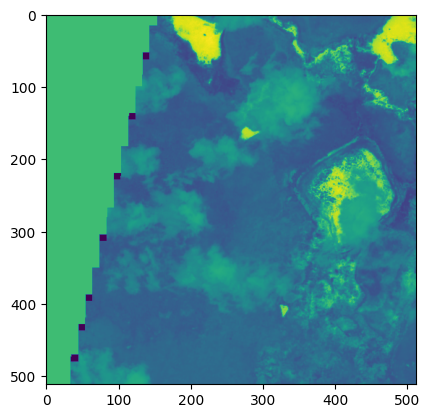

In [69]:
plt.imshow(instance.ndwi_img)

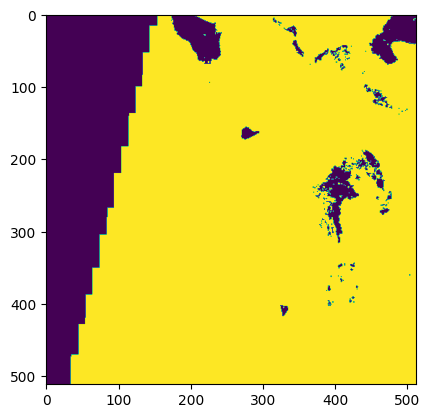

In [70]:
plt.imshow(instance.mask)

In [71]:
instance.mask

array([[0, 0, 0, ..., 1, 1, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 1, 1, 1],
       [0, 0, 0, ..., 1, 1, 1],
       [0, 0, 0, ..., 1, 1, 1]])